# Day 5: Central Limit Theorem & Confidence Intervals
## Week 2: Statistics & Probability for Finance

---

### 🎯 Learning Objectives
- Understand CLT and why it matters for finance
- Construct confidence intervals for returns and Sharpe ratios
- Apply bootstrap methods for robust estimation
- Quantify estimation uncertainty

---

### 📈 Why CLT and Confidence Intervals Matter in Trading

**What is the Central Limit Theorem?**

CLT says that averages of random samples become normally distributed as sample size increases, regardless of the original distribution.

**What are Confidence Intervals?**

A range of values that likely contains the true parameter. A 95% CI means: if we repeated the analysis 100 times, 95 of those intervals would contain the true value.

### Trading Applications

| Concept | Trading Use | Example |
|---------|-------------|---------|
| **CLT** | Validates statistical tests | t-tests work on returns even though returns aren't Normal |
| **CI for Mean** | Is strategy profitable? | If CI includes 0, profit might be luck |
| **CI for Volatility** | Risk budgeting | True vol might be higher than sample vol |
| **CI for Sharpe** | Is Sharpe ratio reliable? | Sharpe = 1.5 with CI [0.3, 2.7] is uncertain |

### ⚠️ Why This Matters

**The Uncertainty Problem:**

A backtest shows 15% annual return. Is it:
- **Statistical noise**: True return is 15% ± 20%?
- **Real edge**: True return is 15% ± 2%?

**Without confidence intervals, you can't tell!**

### Key Insight

With 1 year of daily data (252 observations):
- Mean return estimate is noisy (wide CI)
- Volatility estimate is more precise (narrower CI)
- Sharpe ratio has very wide CI (~±0.4 for Sharpe=1)

In [1]:
# Day 5 Setup: CLT & Confidence Intervals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("CLT & CONFIDENCE INTERVALS - DAY 5")
print("=" * 60)
print(f"\n✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
CLT & CONFIDENCE INTERVALS - DAY 5

✅ Data loaded: 1256 days


## 1. Central Limit Theorem Demonstration

### What CLT States

The distribution of **sample means** approaches Normal as sample size (n) increases, regardless of the underlying distribution.

$$\bar{X} \xrightarrow{d} N\left(\mu, \frac{\sigma^2}{n}\right)$$

### The Magic Number

With n=30+, CLT kicks in even for non-Normal data. For finance (fat tails), n=50+ is safer.

### 🎯 Why This Matters for Trading

**1. Validates Statistical Tests:**
- Returns have fat tails (not Normal)
- But MEAN of returns is approximately Normal (thanks to CLT)
- So t-tests and confidence intervals still work!

**2. Standard Error Formula:**

$$SE = \frac{\sigma}{\sqrt{n}}$$

**3. Sample Size Requirements:**
- To halve your estimation error: need 4x more data
- To get 10% error: need ~100 observations
- For precise Sharpe ratio: need 2-3 years minimum

| Time Period | n (trading days) | SE Reduction |
|-------------|------------------|--------------|
| 1 month | 21 | σ/4.6 |
| 1 quarter | 63 | σ/7.9 |
| 1 year | 252 | σ/15.9 |
| 5 years | 1260 | σ/35.5 |

CENTRAL LIMIT THEOREM DEMONSTRATION

Population: AAPL Daily Returns (n=1255)
True mean: 0.000612
True std:  0.017433


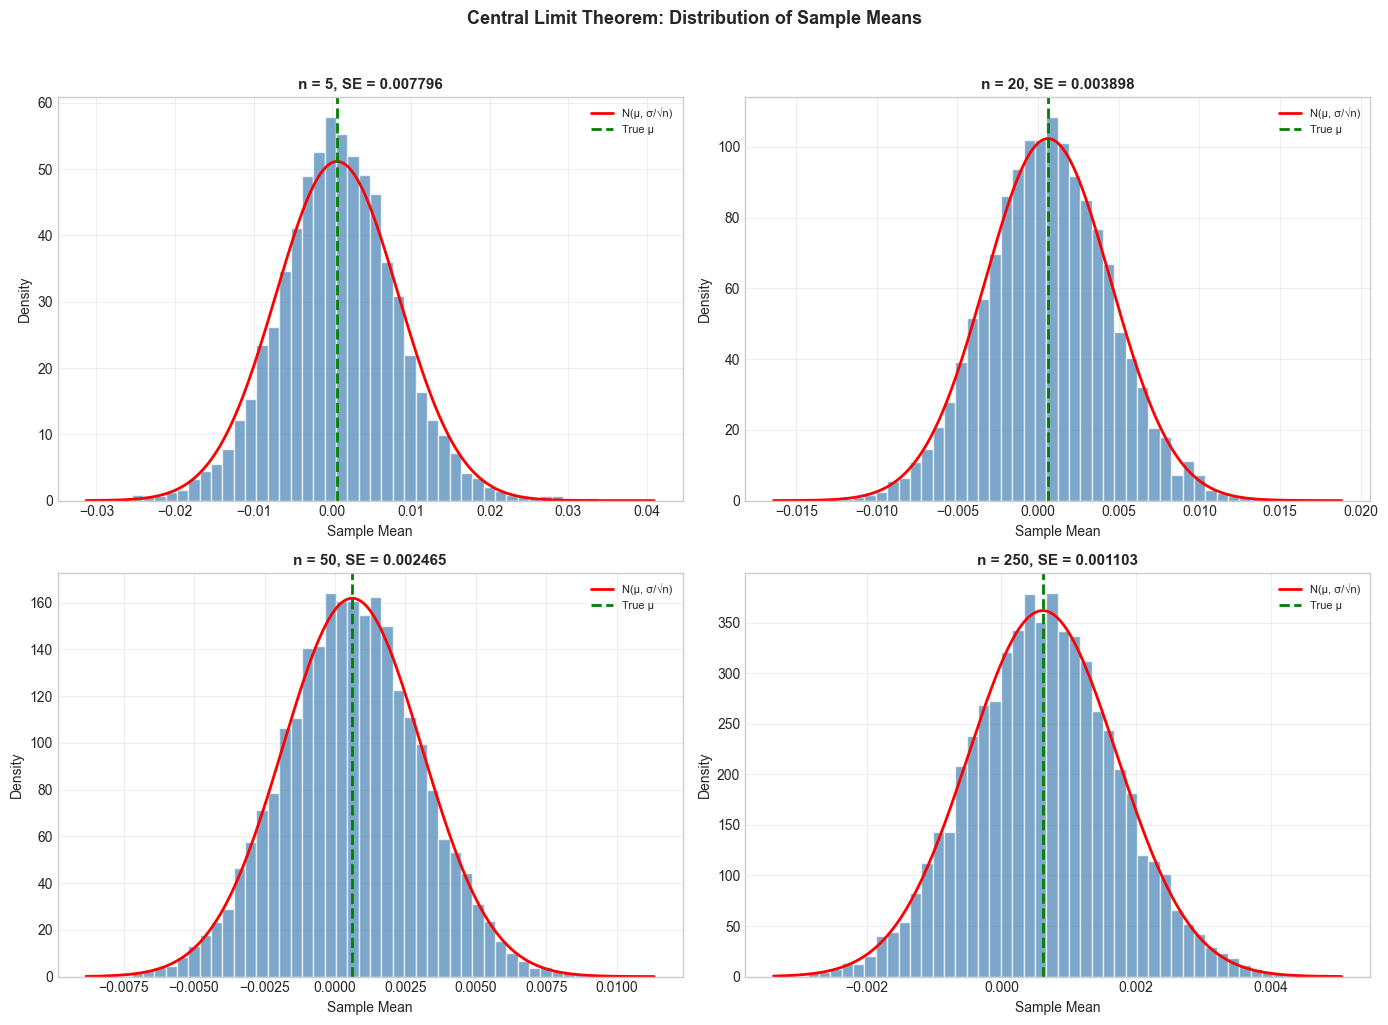


📊 CLT Implications:
   - Larger samples → narrower distribution → more precise estimates
   - Standard Error = σ/√n
   - Works even though returns have fat tails!


In [2]:
# CLT Demonstration with AAPL returns
print("=" * 60)
print("CENTRAL LIMIT THEOREM DEMONSTRATION")
print("=" * 60)

aapl_returns = returns['AAPL'].values
true_mean = np.mean(aapl_returns)
true_std = np.std(aapl_returns, ddof=1)

print(f"\nPopulation: AAPL Daily Returns (n={len(aapl_returns)})")
print(f"True mean: {true_mean:.6f}")
print(f"True std:  {true_std:.6f}")

# Simulate sampling distributions
np.random.seed(42)
sample_sizes = [5, 20, 50, 250]
n_simulations = 10000

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, n in enumerate(sample_sizes):
    # Generate sample means
    sample_means = [np.mean(np.random.choice(aapl_returns, n, replace=True)) 
                    for _ in range(n_simulations)]
    
    # Expected std error
    expected_se = true_std / np.sqrt(n)
    
    # Plot
    axes[i].hist(sample_means, bins=50, density=True, alpha=0.7, 
                 color='steelblue', edgecolor='white')
    
    # Normal fit
    x = np.linspace(min(sample_means), max(sample_means), 200)
    axes[i].plot(x, stats.norm.pdf(x, true_mean, expected_se), 'r-', lw=2, 
                 label=f'N(μ, σ/√n)')
    axes[i].axvline(true_mean, color='green', lw=2, linestyle='--', label='True μ')
    
    axes[i].set_xlabel('Sample Mean', fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].set_title(f'n = {n}, SE = {expected_se:.6f}', fontsize=11, fontweight='bold')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Central Limit Theorem: Distribution of Sample Means', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 CLT Implications:")
print("   - Larger samples → narrower distribution → more precise estimates")
print("   - Standard Error = σ/√n")
print("   - Works even though returns have fat tails!")

## 2. Confidence Intervals for Returns

**Key Insight:** More data = narrower CI = more confidence

### What is a Confidence Interval?

A range [lower, upper] where we expect the true parameter to lie with specified probability.| 95% CI | [7.5%, 12.5%] | [8.9%, 11.1%] |

| SE | 1.26% | 0.56% |

**95% CI Interpretation:**| n | 252 | 1260 |

- "We are 95% confident the true mean return lies in this range"| Volatility | 20% | 20% |

- NOT: "There's 95% probability the true mean is in this range" (subtle but important difference)| Mean Return | 10% | 10% |

|-----------|-------------|-------------|

### 🎯 Trading Application: Is My Strategy Profitable?| Parameter | 1-Year Data | 5-Year Data |

### Practical Example

**Scenario:**

Backtest shows 10% annual return. Is it real?- $n$ = number of observations

- $s$ = sample standard deviation

| CI Result | Interpretation | Action |- $t_{\alpha/2}$ = t-critical value (1.96 for 95% with large n)

|-----------|----------------|--------|- $\bar{r}$ = sample mean return

| CI: [8%, 12%] | Strongly positive | Deploy with confidence |Where:

| CI: [2%, 18%] | Positive but uncertain | Deploy cautiously, size small |

| CI: [-5%, 25%] | **Includes zero!** | Not statistically significant |$$CI = \bar{r} \pm t_{\alpha/2, n-1} \times \frac{s}{\sqrt{n}}$$

| CI: [-8%, 28%] | Very uncertain | Need more data |### Formula for Mean Return CI


CONFIDENCE INTERVALS FOR RETURNS

Sample: n = 1255
Daily mean: 0.000612
Standard error: 0.000492

------------------------------------------------------------

90% Confidence Interval:
  Daily:    [-0.000198, 0.001422]
  Annual:   [-4.99%, 35.83%]

95% Confidence Interval:
  Daily:    [-0.000353, 0.001577]
  Annual:   [-8.91%, 39.75%]

99% Confidence Interval:
  Daily:    [-0.000658, 0.001881]
  Annual:   [-16.57%, 47.41%]


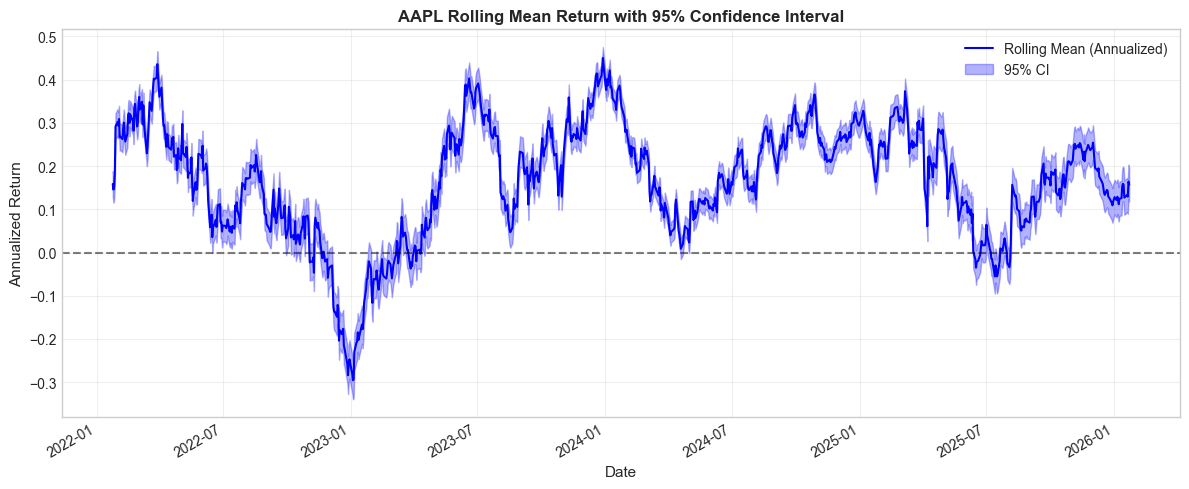

In [3]:
# Confidence Intervals
print("=" * 60)
print("CONFIDENCE INTERVALS FOR RETURNS")
print("=" * 60)

aapl_returns = returns['AAPL'].values
n = len(aapl_returns)

# Point estimates
mean_daily = np.mean(aapl_returns)
std_daily = np.std(aapl_returns, ddof=1)
se_mean = std_daily / np.sqrt(n)

# Confidence levels
confidence_levels = [0.90, 0.95, 0.99]

print(f"\nSample: n = {n}")
print(f"Daily mean: {mean_daily:.6f}")
print(f"Standard error: {se_mean:.6f}")
print("\n" + "-" * 60)

for conf in confidence_levels:
    alpha = 1 - conf
    t_critical = stats.t.ppf(1 - alpha/2, df=n-1)
    margin = t_critical * se_mean
    ci_lower = mean_daily - margin
    ci_upper = mean_daily + margin
    
    # Annualize
    ci_lower_ann = ci_lower * 252
    ci_upper_ann = ci_upper * 252
    
    print(f"\n{conf:.0%} Confidence Interval:")
    print(f"  Daily:    [{ci_lower:.6f}, {ci_upper:.6f}]")
    print(f"  Annual:   [{ci_lower_ann:.2%}, {ci_upper_ann:.2%}]")

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))

# Rolling mean with confidence bands
window = 252
rolling_mean = returns['AAPL'].rolling(window).mean() * 252
rolling_std = returns['AAPL'].rolling(window).std() * np.sqrt(252)
rolling_se = rolling_std / np.sqrt(window)

rolling_mean.plot(ax=ax, color='blue', lw=1.5, label='Rolling Mean (Annualized)')
ax.fill_between(rolling_mean.index, 
                rolling_mean - 1.96 * rolling_se, 
                rolling_mean + 1.96 * rolling_se, 
                alpha=0.3, color='blue', label='95% CI')
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Annualized Return', fontsize=11)
ax.set_title('AAPL Rolling Mean Return with 95% Confidence Interval', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Bootstrap Methods - Robust Estimation

- Can underestimate uncertainty for very fat-tailed data

### What is Bootstrap?- Doesn't work well for very small samples (n < 20)

Bootstrap is a resampling method that estimates uncertainty by repeatedly sampling from your data **with replacement**.- Assumes data is independent (returns are mostly independent)

### ⚠️ Bootstrap Limitations

### Why Bootstrap for Trading?

| Problem | Normal CI | Bootstrap CI || Complex metrics | 500+ | 10,000+ |

|---------|-----------|---------------|| Max Drawdown | 250+ | 10,000 |

| Non-Normal returns | May be wrong | Works anyway || Sharpe Ratio | 100+ | 10,000 |

| Complex statistics (Sharpe, Max DD) | Hard to derive | Easy to compute || Mean | Any | 5,000 |

| Small samples | Unreliable | More robust ||-----------|-------------|----------------------|

| Dependent data | Invalid | Can be adjusted || Statistic | Sample Size | Bootstrap Iterations |

### Practical Guidelines

### 🎯 Trading Applications

```

**1. Sharpe Ratio CI:**5. Take 2.5th and 97.5th percentiles as 95% CI

- No simple formula for Sharpe CI4. Repeat 10,000 times

- Bootstrap: resample returns → calculate Sharpe → get distribution3. Calculate statistic (mean, Sharpe, etc.)

2. Sample n returns WITH REPLACEMENT (some repeated, some missing)

**2. Maximum Drawdown CI:**1. Take your n returns

- Max DD is path-dependent and non-Normal```

- Bootstrap gives realistic range of possible max drawdowns### How Bootstrap Works



**3. Strategy Comparison:**- See if CI excludes zero
- Bootstrap the return difference

BOOTSTRAP CONFIDENCE INTERVALS

Bootstrap Simulation: 10,000 iterations
------------------------------------------------------------

Mean Return (daily):
  Point estimate: 0.000612
  95% Bootstrap CI: [-0.000360, 0.001597]

Sharpe Ratio:
  Point estimate: 0.377
  95% Bootstrap CI: [-0.482, 1.252]


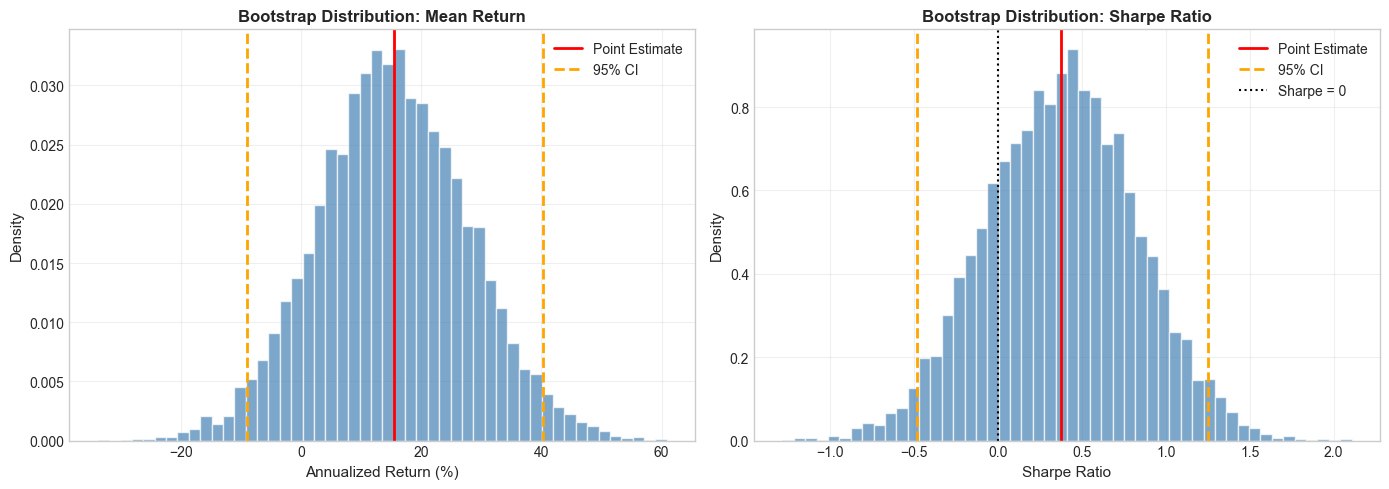


📊 Bootstrap Advantage: No distributional assumptions!


In [4]:
# Bootstrap Confidence Intervals
print("=" * 60)
print("BOOTSTRAP CONFIDENCE INTERVALS")
print("=" * 60)

np.random.seed(42)
aapl_returns = returns['AAPL'].values
n_bootstrap = 10000

def bootstrap_ci(data, statistic_func, n_bootstrap=10000, confidence=0.95):
    """Calculate bootstrap confidence interval for any statistic."""
    n = len(data)
    bootstrap_stats = []
    
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, n, replace=True)
        bootstrap_stats.append(statistic_func(sample))
    
    alpha = 1 - confidence
    lower = np.percentile(bootstrap_stats, alpha/2 * 100)
    upper = np.percentile(bootstrap_stats, (1 - alpha/2) * 100)
    
    return np.array(bootstrap_stats), lower, upper

# Bootstrap for various statistics
print(f"\nBootstrap Simulation: {n_bootstrap:,} iterations")
print("-" * 60)

# Mean
boot_means, mean_lower, mean_upper = bootstrap_ci(aapl_returns, np.mean)
print(f"\nMean Return (daily):")
print(f"  Point estimate: {np.mean(aapl_returns):.6f}")
print(f"  95% Bootstrap CI: [{mean_lower:.6f}, {mean_upper:.6f}]")

# Sharpe Ratio
def sharpe_ratio(r, rf=0.05/252):
    return (np.mean(r) - rf) / np.std(r, ddof=1) * np.sqrt(252)

boot_sharpes, sharpe_lower, sharpe_upper = bootstrap_ci(aapl_returns, sharpe_ratio)
print(f"\nSharpe Ratio:")
print(f"  Point estimate: {sharpe_ratio(aapl_returns):.3f}")
print(f"  95% Bootstrap CI: [{sharpe_lower:.3f}, {sharpe_upper:.3f}]")

# Visualize bootstrap distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean bootstrap
axes[0].hist(boot_means * 252 * 100, bins=50, density=True, alpha=0.7, 
             color='steelblue', edgecolor='white')
axes[0].axvline(np.mean(aapl_returns) * 252 * 100, color='red', lw=2, label='Point Estimate')
axes[0].axvline(mean_lower * 252 * 100, color='orange', lw=2, linestyle='--', label='95% CI')
axes[0].axvline(mean_upper * 252 * 100, color='orange', lw=2, linestyle='--')
axes[0].set_xlabel('Annualized Return (%)', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('Bootstrap Distribution: Mean Return', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sharpe bootstrap
axes[1].hist(boot_sharpes, bins=50, density=True, alpha=0.7, 
             color='steelblue', edgecolor='white')
axes[1].axvline(sharpe_ratio(aapl_returns), color='red', lw=2, label='Point Estimate')
axes[1].axvline(sharpe_lower, color='orange', lw=2, linestyle='--', label='95% CI')
axes[1].axvline(sharpe_upper, color='orange', lw=2, linestyle='--')
axes[1].axvline(0, color='black', lw=1.5, linestyle=':', label='Sharpe = 0')
axes[1].set_xlabel('Sharpe Ratio', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].set_title('Bootstrap Distribution: Sharpe Ratio', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Bootstrap Advantage: No distributional assumptions!")

## 4. How Many Observations Do We Need?

SAMPLE SIZE ANALYSIS: How Long to Detect Signal?

Years needed to detect Sharpe ratio (95% CI, 80% power):
----------------------------------------
True Sharpe     Years Needed   
----------------------------------------
0.5             0.1            
1.0             0.0            
1.5             0.0            
2.0             0.0            
3.0             0.0            


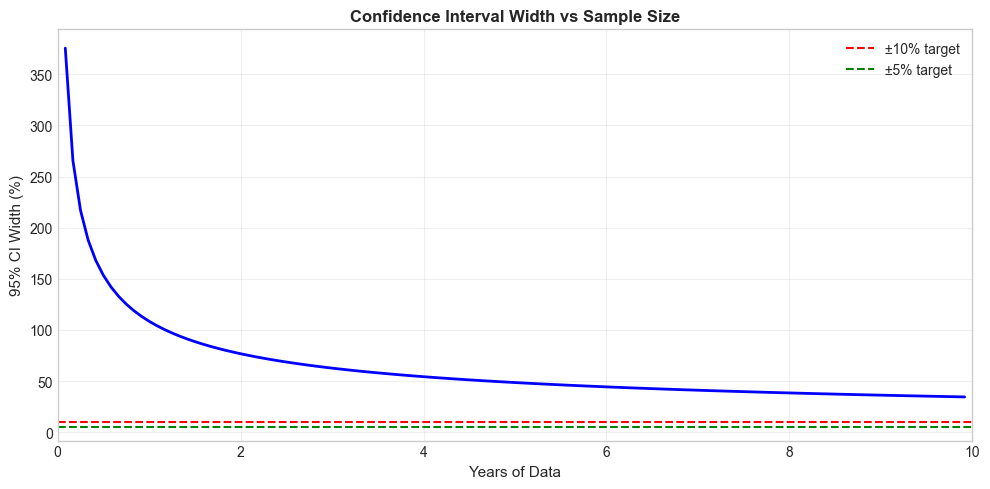


⚠️ Key Insight: Need ~4 years of daily data for reasonably precise estimates!


In [5]:
# Sample Size Analysis
print("=" * 60)
print("SAMPLE SIZE ANALYSIS: How Long to Detect Signal?")
print("=" * 60)

# Given a true Sharpe ratio, how many years to detect it?
def years_to_detect(true_sharpe, confidence=0.95, power=0.80):
    """Calculate years needed to detect a given Sharpe ratio."""
    z_alpha = stats.norm.ppf(1 - (1 - confidence)/2)
    z_beta = stats.norm.ppf(power)
    
    # Standard error of Sharpe ≈ sqrt((1 + 0.5*SR^2) / n)
    # Solve for n: n = (z_alpha + z_beta)^2 * (1 + 0.5*SR^2) / SR^2
    n_days = ((z_alpha + z_beta)**2 * (1 + 0.5 * true_sharpe**2)) / true_sharpe**2
    n_years = n_days / 252
    
    return n_years

sharpe_values = [0.5, 1.0, 1.5, 2.0, 3.0]
print(f"\nYears needed to detect Sharpe ratio (95% CI, 80% power):")
print("-" * 40)
print(f"{'True Sharpe':<15} {'Years Needed':<15}")
print("-" * 40)
for sr in sharpe_values:
    years = years_to_detect(sr)
    print(f"{sr:<15.1f} {years:<15.1f}")

# Visualize CI width vs sample size
sample_sizes = np.arange(21, 2520, 21)  # 1 month to 10 years
ci_widths = []

for n in sample_sizes:
    se = np.std(aapl_returns) / np.sqrt(n)
    width = 2 * 1.96 * se * 252 * 100  # Annualized percentage
    ci_widths.append(width)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sample_sizes / 252, ci_widths, 'b-', lw=2)
ax.axhline(10, color='red', linestyle='--', label='±10% target')
ax.axhline(5, color='green', linestyle='--', label='±5% target')
ax.set_xlabel('Years of Data', fontsize=11)
ax.set_ylabel('95% CI Width (%)', fontsize=11)
ax.set_title('Confidence Interval Width vs Sample Size', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 10)
plt.tight_layout()
plt.show()

print("\n⚠️ Key Insight: Need ~4 years of daily data for reasonably precise estimates!")

## 📝 Key Takeaways - Day 5

### Central Limit Theorem:
- Sample means → Normal as n increases
- Standard Error = σ / √n
- Works even for non-Normal returns

### Confidence Intervals:
- Parametric: Assume underlying distribution
- Bootstrap: No distributional assumptions
- Wider CI = more uncertainty

### Sample Size Rules of Thumb:
- Sharpe 0.5 → ~16 years to detect
- Sharpe 1.0 → ~4 years to detect
- Sharpe 2.0 → ~1 year to detect

### Interview Questions:
- "How long would you backtest a strategy?"
- "What's the standard error of the Sharpe ratio?"
- "When would you use bootstrap vs parametric CI?"
- "How does sample size affect estimation precision?"

## 🔴 PROS & CONS: CLT Confidence Intervals

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [6]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - CLT Confidence Intervals Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-24 09:50

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $248.04
   GOOGL: $327.93
   GS: $918.88
   JPM: $297.72
   MSFT: $465.95

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -9.41%
   🟢 GOOGL: +4.41%
   🟢 GS: +0.89%
   🔴 JPM: -9.15%
   🔴 MSFT: -4.52%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟡 NEUTRAL - Hold current positions
   GS: 🟡 NEUTRAL - Hold current positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🟡 NEUTRAL - Hold current positions

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
